## **Обработка данных**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import time
import dill
import re

from geopy.geocoders import Nominatim
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### *Функции*

In [2]:
# возвращает True, если в строке содержится число
def get_digits(description):
    res = re.search(r'[0-9]+', description)
    if res:
        return True

In [3]:
# выводит статистику по заполненности набора данных
def print_stats(df):
    print(f"Количество полностью заполненных объектов: {len(df.dropna())}")
    print(f"Процент полностью заполненных объектов: {round(len(df.dropna()) / (len(df) / 100), 2)}")

In [4]:
# выводит процент пропущенных значений
def print_missing_values(df):
    percent_missing = (df.isna().sum() / (len(df) / 100)).sort_values(ascending=False)
    print(f"Процент пропущенных значений:\n{percent_missing}")

In [5]:
# принимает датафрейм df с filling_col, где есть пропуски, и filled_col, по которой эти пропуски будут заполняться соответствующим самым часто встречаемым значением среди строк с заполенной filling_col
def change_nans(df, filled_col, filling_col):
    df_fill = df[~(df[filling_col].isna())]
    list_cols = list(df_fill[filled_col].unique())
    for col in list_cols:
        df.loc[((df[filled_col].isin(list_cols)) & (df[filling_col].isna())), filling_col] = df_fill[df_fill[filled_col] == col][filling_col].describe()['top']
    return df

In [6]:
# расчёт интерквантильного размаха
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [7]:
# проверка вхождения метрики в границы нормальных значений
def get_and_check_min_max_bounds(data, str_metric):
    bounds = calculate_outliers(data[str_metric])
    
    if str(data[str_metric].dtype).find('int') >= 0:
        bounds = (int(round(bounds[0], 0)), int(round(bounds[1], 0)))

    if data[str_metric].min() > bounds[0]:
        print("min входит в границы нормальных значений")
    else:
        print("min не входит в границы нормальных значений")
        
    if data[str_metric].max() < bounds[1]:
        print("max входит в границы нормальных значений")
    else:
        print("max не входит в границы нормальных значений")
        
    return bounds

### Data Preparation

##### Загрузка данных 

In [48]:
df_sessions = 0
with open("data/ga_sessions.pkl", 'rb') as f:
    df_sessions = dill.load(f)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [49]:
print_stats(df_sessions)

Количество полностью заполненных объектов: 14940
Процент полностью заполненных объектов: 0.8


In [50]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
utm_adcontent               18.043410
utm_campaign                11.806346
device_brand                 6.380394
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64


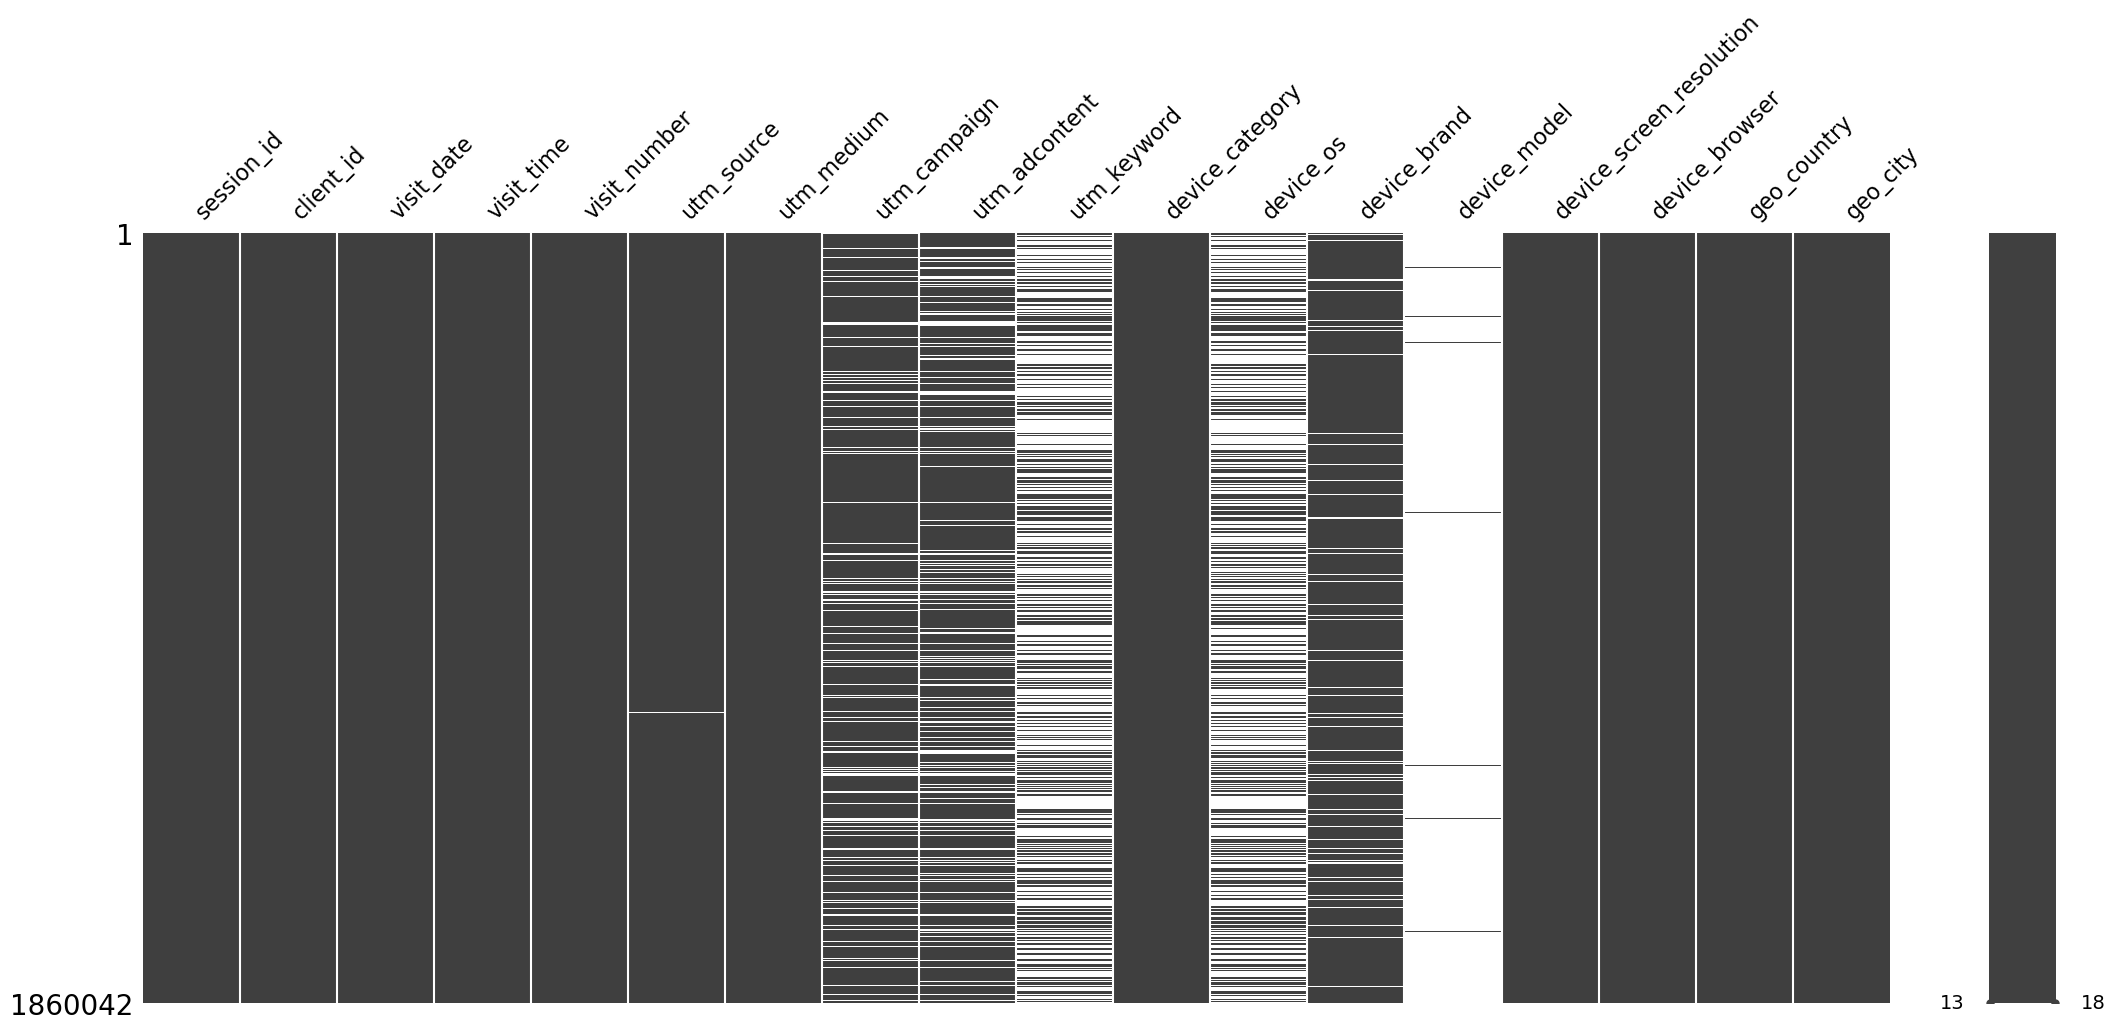

In [51]:
msno.matrix(df_sessions);

Наблюдаем, что device_model практически пустой, utm_keyword и device_os заполнены лишь наполовину, и если device_os можно восстановить по более заполненному device_brand, то в device_model и utm_keyword содержится информация, которую логически не восстановить. Эти столбцы удаляем сразу

In [52]:
df_sessions = df_sessions.drop(columns=['device_model', 'utm_keyword'])

##### Обработка пропусков utm_source

Для начала уберём пропуски из фичи, которую можно будет использовать для заполнения пустых данных в других признаках 

In [53]:
df_sessions.loc[(df_sessions['utm_source'].isna())].shape

(97, 16)

In [54]:
df_sessions.loc[(df_sessions['utm_source'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
77652,1100240274910044288.1640728207.1640728207,256169651.1637310592,2021-12-29,00:50:07,2,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,OnePlus,412x892,Chrome,Russia,Saint Petersburg
122841,1303431342277938317.1637250145.1637250145,303478758.1637239949,2021-11-18,18:42:25,3,NaN,Sbol_catalog,cccMlyVfjXspfaCSrMsO,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Balashikha
136220,1364914954463538089.1637595059.1637595059,317794027.1634397097,2021-11-22,18:30:59,8,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,YaBrowser,Russia,Moscow
136221,1364914954463538089.1638478637.1638478637,317794027.1634397097,2021-12-02,23:57:17,9,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,YaBrowser,Russia,Moscow
139706,1380043242326371104.1637518268.1637518268,321316356.1636477728,2021-11-21,21:11:08,4,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,360x740,Chrome,Russia,Izhevsk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629120,8025307339522195714.1638678933.1638678933,1868537473.1636712706,2021-12-05,07:35:33,13,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,360x780,Chrome,Russia,Sochi
1629121,8025307339522195714.1638688249.1638688249,1868537473.1636712706,2021-12-05,10:10:49,14,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,360x780,Chrome,Russia,Krasnodar
1629122,8025307339522195714.1638954236.1638954236,1868537473.1636712706,2021-12-08,12:03:56,15,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,360x780,Chrome,Ukraine,Pereval's'k
1732460,848873006059532776.1637459623.1637459623,197643648.1637396968,2021-11-21,04:53:43,2,NaN,(not set),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,360x800,Chrome,Russia,Novosibirsk


In [55]:
df_sessions = df_sessions.loc[~(df_sessions['utm_source'].isna())]
#df_sessions.loc[(df_sessions['utm_source'].isna())]['utm_medium'].unique()

In [56]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_os                   57.536002
utm_adcontent               18.042200
utm_campaign                11.806962
device_brand                 6.377931
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка пропусков device_brand

Бренд можно точно определить по специфическим браузерам и ОС. Впоследствии эта фича поможет нам устранить пропуски в данных о модели и ОС

In [57]:
# маска для неопределённого device_brand - not set, пустая строка и NaN
mask_undef_brand = ((df_sessions['device_brand'] == '(not set)') | (df_sessions['device_brand'] == '') | (df_sessions['device_brand'].isna()))

In [58]:
df_sessions.loc[(((df_sessions['device_browser'] == 'Safari') | (df_sessions['device_browser'] == '[FBAN')) & mask_undef_brand), 'device_brand']  = 'Apple'

In [59]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_browser'] == 'Samsung Internet')), 'device_brand'] = 'Samsung'

In [60]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'] == 'Macintosh')), 'device_brand'] = 'Apple'

In [61]:
df_sessions[mask_undef_brand]['device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Safari', 'Firefox', 'Opera', 'Edge',
       'helloworld', 'Instagram 208.0.0.32.135 Android',
       'Android Webview', 'Instagram 209.0.0.21.119 Android',
       'Samsung Internet', 'Mozilla Compatible Agent', '(not set)',
       'Mozilla', 'Coc Coc', 'Instagram 213.0.0.29.120 Android',
       'Android', 'Instagram 216.1.0.21.137 Android', '[FBAN',
       'Internet Explorer', 'MRCHROME', 'Opera Mini', 'com.vk.vkclient',
       'Puffin', 'Instagram 199.1.0.34.119 Android', 'UC Browser',
       'Maxthon', 'SeaMonkey', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Android', 'Android Browser',
       'Instagram 158.0.0.30.123 Android', 'Android Runtime',
       'Instagram 206.1.0.34.121 Android', 'Konqueror',
       'Threads 202.0.0.23.119'], dtype=object)

Приложение Threads закрыто в 2021-м году, поэтому данные, где оно используется, не пригодятся нам в анализе. Удаляем их

In [62]:
df_sessions = df_sessions[~(df_sessions['device_browser'].str.contains('Threads'))]

In [63]:
df_sessions[(df_sessions['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha
67,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg
79,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow
90,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
91,9055853019573035768.1640843475.1640843475,2108480087.1640801016,2021-12-30,08:51:15,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859999,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan
1860008,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar
1860025,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow


In [64]:
df_sessions[(df_sessions['device_brand'].isna())]['device_os'].unique()

array(['Windows', 'Linux', '(not set)', 'Chrome OS', 'Macintosh'],
      dtype=object)

In [65]:
df_sessions[(df_sessions['device_brand'].isna())]['device_os'].describe()

count       93706
unique          5
top       Windows
freq        88298
Name: device_os, dtype: object

In [66]:
df_sessions.loc[((df_sessions['device_brand'].isna()) & (df_sessions['device_category'] == 'desktop'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
28,9055505230298952295.1638478433.1638478433,2108399111.1638478439,2021-12-02,23:53:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1536x864,Chrome,Russia,Balashikha
67,9055678214400253418.1636965866.1636965866,2108439387.1636965866,2021-11-15,11:44:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1920x1080,Chrome,Russia,Saint Petersburg
79,9055795561498027164.1638278300.1638278300,2108466709.1638278300,2021-11-30,16:18:20,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Windows,None,1680x1050,Chrome,Russia,Moscow
90,9055853019573035768.1640801016.1640801016,2108480087.1640801016,2021-12-29,21:03:36,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
91,9055853019573035768.1640843475.1640843475,2108480087.1640801016,2021-12-30,08:51:15,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1024x820,YaBrowser,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859999,9055247549438461124.1635878086.1635878086,2108339115.1635878084,2021-11-02,21:34:46,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,None,1366x768,Chrome,Russia,Kazan
1860008,9055283330814105899.1638979884.1638979890,2108347446.1638979883,2021-12-08,19:11:30,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Windows,None,1920x1080,Chrome,Russia,Krasnodar
1860025,9055354507009984602.1636829278.1636829278,2108364018.1636829274,2021-11-13,21:47:58,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Windows,None,1366x768,Firefox,Russia,Balashikha
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,None,1920x1080,Chrome,Russia,Moscow


In [67]:
df_sessions.loc[(mask_undef_brand & (df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'] != 'Macintosh')), 'device_brand'] = 'other'

In [68]:
df_sessions.loc[(df_sessions['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
119227,128743428747935717.1638907878.1638907878,29975415.1638907877,2021-12-07,23:11:18,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x851,Chrome,Russia,(not set)
121378,1296701003971072834.1637258051.1637258051,301911729.1637258050,2021-11-18,20:54:11,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,851x393,Chrome,Russia,Moscow
137577,1371041858455442706.1636723488.1636723488,319220558.1634571538,2021-11-12,16:24:48,6,kjsLglQLzykiRbcDiGcD,cpc,nSReTmyFtbSjlPrTKoaX,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,424x942,Chrome,Russia,Nizhny Novgorod
265642,1946178047144129078.1638953526.1638953526,453129887.1638953526,2021-12-08,11:52:06,1,kjsLglQLzykiRbcDiGcD,cpc,WlbWUObZWvsimzdFdLYw,JNHcPlZPxEMWDnRiyoBf,mobile,Windows,None,1920x1080,Edge,Russia,Moscow
276129,1993060007474941190.1637141768.1637141768,464045444.1637141766,2021-11-17,12:36:08,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,360x720,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671089,8213511827182896805.1639303366.1639303366,1912357245.1639237285,2021-12-12,13:02:46,2,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x830,Chrome,Russia,Saint Petersburg
1704802,8365118374521985765.1635375847.1635375847,1947655895.1635375845,2021-10-28,02:04:07,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,1600x1200,Chrome,India,Gurgaon
1716387,8416888273925634168.1635580025.1635580025,1959709514.1635580024,2021-10-30,10:47:05,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,tablet,Linux,None,1600x1200,Chrome,India,Gurgaon
1724652,8453794644430050718.1636119335.1636119335,1968302448.1633310110,2021-11-05,16:35:35,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Linux,None,412x915,Chrome,Russia,Saint Petersburg


In [69]:
df_sessions.loc[((df_sessions['device_brand'].isna()) & (df_sessions['device_os'] == 'Macintosh')), 'device_brand'] = 'Apple'

In [70]:
df_sessions.loc[(df_sessions['device_brand'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
119227,128743428747935717.1638907878.1638907878,29975415.1638907877,2021-12-07,23:11:18,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x851,Chrome,Russia,(not set)
121378,1296701003971072834.1637258051.1637258051,301911729.1637258050,2021-11-18,20:54:11,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,851x393,Chrome,Russia,Moscow
137577,1371041858455442706.1636723488.1636723488,319220558.1634571538,2021-11-12,16:24:48,6,kjsLglQLzykiRbcDiGcD,cpc,nSReTmyFtbSjlPrTKoaX,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,424x942,Chrome,Russia,Nizhny Novgorod
265642,1946178047144129078.1638953526.1638953526,453129887.1638953526,2021-12-08,11:52:06,1,kjsLglQLzykiRbcDiGcD,cpc,WlbWUObZWvsimzdFdLYw,JNHcPlZPxEMWDnRiyoBf,mobile,Windows,None,1920x1080,Edge,Russia,Moscow
276129,1993060007474941190.1637141768.1637141768,464045444.1637141766,2021-11-17,12:36:08,1,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,360x720,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671089,8213511827182896805.1639303366.1639303366,1912357245.1639237285,2021-12-12,13:02:46,2,kjsLglQLzykiRbcDiGcD,cpc,UjApcvnaHtkydRkrLYuv,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,393x830,Chrome,Russia,Saint Petersburg
1704802,8365118374521985765.1635375847.1635375847,1947655895.1635375845,2021-10-28,02:04:07,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,mobile,Linux,None,1600x1200,Chrome,India,Gurgaon
1716387,8416888273925634168.1635580025.1635580025,1959709514.1635580024,2021-10-30,10:47:05,1,kjsLglQLzykiRbcDiGcD,cpc,xhbLYKykcxmylecTsBop,JNHcPlZPxEMWDnRiyoBf,tablet,Linux,None,1600x1200,Chrome,India,Gurgaon
1724652,8453794644430050718.1636119335.1636119335,1968302448.1633310110,2021-11-05,16:35:35,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Linux,None,412x915,Chrome,Russia,Saint Petersburg


In [71]:
df_sessions.loc[(df_sessions['device_brand'].isna()), 'device_os'].unique()

array(['Linux', 'Windows'], dtype=object)

In [72]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]['device_browser'].unique()

array(['Chrome', 'Firefox', 'Opera', 'YaBrowser', 'Android Webview',
       'Mozilla', 'Opera Mini', 'com.vk.vkclient', 'UC Browser',
       'Internet Explorer', 'Android Browser', 'Android Runtime'],
      dtype=object)

In [73]:
df_sessions.loc[(df_sessions['device_brand'].isna()), 'device_brand'] = 'other'

In [74]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]['device_os'].unique()

array([None, 'Android', '(not set)', 'Windows Phone'], dtype=object)

In [75]:
df_sessions[(df_sessions['device_brand'] == '(not set)')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
83,9055834796008808950.1622811129.1622811129,2108475844.1622811126,2021-06-04,15:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),360x640,Chrome,Russia,Chelyabinsk
127,9056013556852379550.1632554912.1632554912,2108517465.1632554910,2021-09-25,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,mobile,None,(not set),342x741,Firefox,Russia,Kazan
165,9056202067269505745.1640092368.1640092368,2108561356.1640092369,2021-12-21,16:12:48,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,Android,(not set),384x854,Chrome,Russia,Moscow
208,9056422519349747445.1638964982.1638964982,2108612684.1638964981,2021-12-08,15:03:02,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg
209,9056422519349747445.1638966940.1638966940,2108612684.1638964981,2021-12-08,15:35:40,2,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,(not set),320x640,Chrome,Russia,Saint Petersburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859362,9052676375860711226.1639943995.1639943995,2107740467.1639943994,2021-12-19,22:59:55,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),393x873,Chrome,Russia,Izhevsk
1859535,9053425229175288131.1636659526.1636659526,2107914823.1636659523,2021-11-11,22:38:46,1,faqsogjxCvbseFqupueU,banner,dZqEgyoxhtbeLFMtnnVR,JNHcPlZPxEMWDnRiyoBf,mobile,Android,(not set),385x769,Chrome,Russia,Samara
1859612,9053730012943175107.1640761072.1640761072,2107985786.1640320451,2021-12-29,09:57:52,2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,(not set),360x760,Chrome,Russia,Vladivostok
1859732,9054179214979411516.1637002817.1637002817,2108090374.1637002812,2021-11-15,22:00:17,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,mobile,Android,(not set),396x858,Firefox,Russia,Saint Petersburg


In [76]:
df_sessions.loc[(df_sessions['device_brand'] == '(not set)'), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [77]:
df_sessions.loc[((df_sessions['device_brand'] == '(not set)') | (df_sessions['device_brand'] == '')), 'device_brand'] = 'other'

In [78]:
print_missing_values(df_sessions)

Процент пропущенных значений:
device_os                   57.535980
utm_adcontent               18.042210
utm_campaign                11.806968
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка пропущенных значений device_os

In [79]:
df_sessions['device_os'].describe()

count      789807
unique         13
top       Android
freq       464019
Name: device_os, dtype: object

Запоминаем отдельно самые часто встречающиеся значения для каждой категории

In [80]:
top_device_os_m = df_sessions.loc[(df_sessions['device_category'] == 'mobile'), 'device_os'].describe()['top']
top_device_os_t = df_sessions.loc[(df_sessions['device_category'] == 'tablet'), 'device_os'].describe()['top']
top_device_os_d = df_sessions.loc[(df_sessions['device_category'] == 'desktop'), 'device_os'].describe()['top']

In [81]:
df_do_fill = df_sessions[~(df_sessions['device_os'].isna())]
df_do_fill 

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
6,9055455318486370642.1640843788.1640843788,2108387490.1640843602,2021-12-30,08:56:28,1,TxKUcPpthBDPieTGmVhx,cpc,FTjNLDyTrXaWYgZymFkV,LcGIUNPUAmXtQJaDfFBR,tablet,Android,Lenovo,602x1029,YaBrowser,Russia,Saint Petersburg
8,9055462349345527315.1638536723.1638536723,2108389127.1638536723,2021-12-03,16:05:23,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,iOS,Apple,390x844,Safari,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860036,9055401700113249881.1639446112.1639446112,2108375006.1639446105,2021-12-14,04:41:52,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Android,ZTE,360x640,Chrome,Russia,Blagoveshchensk
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk


In [82]:
df_sessions[df_sessions['device_os'].isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,None,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,None,Xiaomi,393x786,Chrome,Russia,Moscow
5,9055447192389856083.1622453074.1622453074,2108385598.1622453075,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,Apple,375x812,Safari,Russia,Saint Petersburg
7,9055461992850812764.1626107740.1626107740,2108389044.1626107740,2021-07-12,19:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,None,Samsung,360x640,Chrome,Russia,Saint Petersburg
9,9055466554104774132.1624800757.1624800757,2108390106.1624800756,2021-06-27,16:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,None,Samsung,412x915,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860030,9055382948278467242.1631877802.1631877802,2108370640.1631877802,2021-09-17,14:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,None,Xiaomi,393x851,Chrome,Russia,Saint Petersburg
1860032,9055394269810294140.1629912447.1629912447,2108373276.1629912444,2021-08-25,20:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,None,Samsung,360x800,Android Webview,Russia,Saint Petersburg
1860034,9055397194683347295.1630237022.1630237022,2108373957.1630237023,2021-08-29,14:00:00,1,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,mobile,None,Apple,414x896,Safari,Russia,Zheleznodorozhny
1860035,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,mobile,None,Samsung,320x676,Chrome,Russia,Naro-Fominsk


Во многих случаях случаях device_os зависит от device_brand, и в этих записях мы точно можем заполнить отсутствующие значения

In [83]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].describe()

count     231876
unique         3
top          iOS
freq      207094
Name: device_os, dtype: object

In [84]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].unique()

array([None, 'iOS', 'Macintosh', 'Windows Phone'], dtype=object)

Исправляем явную ошибку в данных

In [85]:
df_sessions.loc[((df_sessions['device_brand'] == 'Apple') & (df_sessions['device_os'] == 'Windows Phone')), 'device_os'] = 'iOS'

In [86]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_os'].unique()

array([None, 'iOS', 'Macintosh'], dtype=object)

In [87]:
df_sessions.loc[(df_sessions['device_brand'] == 'Apple'), 'device_category'].unique()

array(['mobile', 'tablet', 'desktop'], dtype=object)

Для всех мобильных устройств бренда Apple, у которых не определена ОС, задать iOS

In [88]:
df_sessions.loc[((df_sessions['device_brand'] == 'Apple') & ((df_sessions['device_category'] == 'mobile') | (df_sessions['device_category'] == 'tablet')) & (df_sessions['device_os'].isna())), 'device_os']  = 'iOS'

Посмотрим на бренд Blackberry

In [89]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'].unique()

array([None, 'Android', 'BlackBerry'], dtype=object)

In [90]:
df_sessions.loc[((df_sessions['device_brand'] == 'BlackBerry') & (df_sessions['device_os'] == 'BlackBerry'))].shape

(27, 16)

In [91]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'].describe()

count          92
unique          2
top       Android
freq           65
Name: device_os, dtype: object

BlackBerry OS - достаточно редкая в текущее время система, и при анализе она не окажет существенного влияния на результат, поэтому заполняем device_os для этого бренда значением самой часто встречаемой ОС  

In [92]:
df_sessions.loc[(df_sessions['device_brand'] == 'BlackBerry'), 'device_os'] = top_device_os_m

In [93]:
df_sessions.loc[(df_sessions['device_brand'] != 'Apple'), 'device_os'].unique()

array(['Android', None, 'Windows', 'Linux', '(not set)', 'Chrome OS',
       'Tizen', 'Firefox OS', 'Samsung', 'Windows Phone', 'Nokia'],
      dtype=object)

In [94]:
print(f"Самые часто встречаемые мобильные ОС: {top_device_os_m} \nПланшетные ОС: {top_device_os_t}")

Самые часто встречаемые мобильные ОС: Android 
Планшетные ОС: Android


Возьмём заполненные данные и вытащим из них список всех остальных брендов

In [95]:
list_brands = df_do_fill.loc[((df_do_fill['device_os'] != 'iOS') & ((df_do_fill['device_category'] == 'mobile') | (df_do_fill['device_category'] == 'tablet'))), 'device_brand'].unique()
list_brands

array(['Huawei', 'Samsung', 'Lenovo', 'Xiaomi', 'Meizu', 'OnePlus',
       'Realme', 'OPPO', 'other', 'Philips', 'Vivo', 'Nokia', 'Alcatel',
       'LG', 'BQ', 'Tecno', 'Asus', 'itel', 'Infinix', 'ZTE', 'Wiko',
       'Google', 'Sony', 'Wileyfox', 'Blackview', 'Cubot', 'DOOGEE',
       'DEXP', 'Motorola', 'TP-Link', 'Hisense', 'Acer', 'Oukitel',
       'LeEco', 'Prestigio', 'POCO', 'Vsmart', 'HTC', 'Ulefone', 'CAT',
       'Leagoo', 'InFocus', 'Inoi', 'BlackBerry', 'Micromax', 'Umidigi',
       'Sharp', 'Jiake', 'ZOJI', 'Yuntab', 'Mozilla', 'Neffos',
       'Highscreen', 'Karbonn', 'TCL', 'BLU', 'Haier', 'Vertex',
       'Coolpad', 'HOMTOM', 'LeTV', 'A1', 'Apple', 'General Mobile',
       'Gome', 'Egreat', 'Mito', 'SenseIT', 'Archos', 'Keecoo', 'Vernee',
       'Panasonic', 'InnJoo', 'Iris', 'Black Fox', 'Lava', 'myPhone',
       'Nomu', 'AGM', 'Nuu', 'UGOOS', 'Alldocube', 'MTC', 'Komu', 'Qbex',
       'Symphony', 'Wigor', 'Oysters', 'Fly', 'Gionee', 'Artel', 'Ananda',
       'Smartisa

In [96]:
df_sessions.loc[((df_sessions['device_brand'].isin(list(list_brands))) & (df_sessions['device_category'] == 'mobile') & (df_sessions['device_os'].isna())), 'device_os'] = top_device_os_m
df_sessions.loc[((df_sessions['device_brand'].isin(list(list_brands))) & (df_sessions['device_category'] == 'tablet') & (df_sessions['device_os'].isna())), 'device_os'] = top_device_os_t

Теперь проверяем характеристики device_browser и device_category

In [97]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Safari', 'Firefox', 'Opera', 'Edge',
       'Instagram 208.0.0.32.135 Android',
       'Instagram 209.0.0.21.119 Android', '(not set)',
       'Mozilla Compatible Agent', 'Coc Coc', 'Samsung Internet',
       'Android', '[FBAN', 'Puffin', 'Internet Explorer', 'MRCHROME',
       'Instagram 199.1.0.34.119 Android', 'UC Browser', 'SeaMonkey',
       'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android', 'Mozilla',
       'Instagram 192.0.0.35.123 Android', 'Maxthon', 'Android Webview',
       'Instagram 158.0.0.30.123 Android', 'Konqueror'], dtype=object)

Встроенные браузеры так же позволяют однозначно определить систему

In [98]:
# маска для неопределённой device_os
mask_undef_os = ((df_sessions['device_os'].isna()) | (df_sessions['device_os'] == '(not set)') | (df_sessions['device_os'] == ''))

In [99]:
df_sessions.loc[((df_sessions['device_browser'] == 'Safari') & (mask_undef_os) & (df_sessions['device_category'] == 'desktop')), 'device_os'] = 'Macintosh'

In [100]:
df_sessions.loc[((df_sessions['device_browser'] == 'Safari') & (mask_undef_os) & (df_sessions['device_category'] != 'desktop')), 'device_os'] = 'iOS'

In [101]:
df_sessions.loc[((mask_undef_os) & (df_sessions['device_browser'] == 'Samsung Internet')), 'device_os'] = 'Android'

In [102]:
df_sessions.loc[((mask_undef_os) & ((df_sessions['device_browser'] == 'Edge') | (df_sessions['device_browser'] == 'Internet Explorer'))), 'device_os'] = 'Windows'

In [103]:
df_sessions.loc[((mask_undef_os) & (df_sessions['device_browser'].str.contains('Android', na=False))), 'device_os'] = 'Android' 

In [104]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_category'].unique()

array(['desktop'], dtype=object)

In [105]:
df_sessions.loc[((df_sessions['device_browser'] == 'Mozilla Compatible Agent') & (df_sessions['device_os'].isna())), 'device_category'].unique()

array(['desktop'], dtype=object)

In [106]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_os'].describe()

count           302
unique            3
top       (not set)
freq            260
Name: device_os, dtype: object

In [107]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent'), 'device_brand'].describe()

count       362
unique        2
top       other
freq        335
Name: device_brand, dtype: object

In [108]:
df_sessions.loc[(df_sessions['device_browser'] == 'Mozilla Compatible Agent')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
8519,9093064959820033783.1637871353.1637871353,2117144167.1637871351,2021-11-25,23:15:53,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Iran,(not set)
10828,9102899502911587345.1629488145.1629488145,2119433950.1629488145,2021-08-20,22:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Saint Petersburg
24764,9164669134152695542.1630043894.1630043894,2133815813.1630043894,2021-08-27,08:00:00,1,nSReTmyFtbSjlPrTKoaX,banner,BVKxkCOHKUOvkpbrLMgZ,JNHcPlZPxEMWDnRiyoBf,desktop,None,other,768x1024,Mozilla Compatible Agent,Russia,Moscow
29900,9187225035383329340.1637438015.1637438015,2139067518.1637438012,2021-11-20,22:53:35,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,Nizhny Tagil
31090,9192716748074205719.1639924247.1639924247,2140346157.1639924247,2021-12-19,17:30:47,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,800x600,Mozilla Compatible Agent,Russia,(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858913,905062508407902236.1630359614.1630359614,210726286.1630359580,2021-08-31,00:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1858914,905062508407902236.1630359673.1630359673,210726286.1630359580,2021-08-31,00:00:00,3,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1858915,905062508407902236.1630359674.1630359674,210726286.1630359580,2021-08-31,00:00:00,4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,desktop,None,other,1920x1080,Mozilla Compatible Agent,Russia,Saint Petersburg
1859651,9053936214320221766.1637486150.1637486167,2108033796.1637486150,2021-11-21,12:16:07,1,bByPQxmDaMXgpHeypKSM,referral,QdLfySaGXolfTBSNVfHn,SOkCdPxfUcZUzzOdgGES,desktop,Linux,other,1600x900,Mozilla Compatible Agent,Russia,Moscow


Mozilla Compatible Agent определяется как браузер в данных траффика в случаях, когда реальные люди заходят через VPN, когда заходят боты или происходит ошибка в whois, к тому же, этих данных немного, поэтому их можно удалить

In [109]:
df_sessions = df_sessions.loc[~(df_sessions['device_browser'] == 'Mozilla Compatible Agent')]

FBAN - это встроенный в приложение Facebook браузер на iOS, поэтому его мы тоже можем определить

In [110]:
df_sessions.loc[((mask_undef_os) & (df_sessions['device_browser'] == '[FBAN')), 'device_os']  = 'iOS'

Посмотрим, какие ещё строки у нас остались с незаполненным device_os

In [111]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].unique()

array(['YaBrowser', 'Chrome', 'Firefox', 'Opera', '(not set)', 'Coc Coc',
       'Puffin', 'MRCHROME', 'UC Browser', 'SeaMonkey', 'Mozilla',
       'Maxthon', 'Konqueror'], dtype=object)

In [112]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].describe()

count     210306
unique        13
top       Chrome
freq      147484
Name: device_browser, dtype: object

In [113]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [114]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].describe()

count      210306
unique          3
top       desktop
freq       210239
Name: device_category, dtype: object

Рассмотрим категорию desktop

In [115]:
df_sessions.loc[(df_sessions['device_category'] == 'desktop'), 'device_os'].describe()

count      156210
unique          8
top       Windows
freq        98112
Name: device_os, dtype: object

In [116]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (mask_undef_os)), 'device_brand'].unique()

array(['other', 'Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Nokia', 'Asus',
       'Beelink', 'OPPO', 'OnePlus', 'Philips', 'Realme'], dtype=object)

Очевидно, что декстопный компьютер бренда Apple управляется ОС Macintosh

In [117]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (mask_undef_os) & (df_sessions['device_brand'] == 'Apple')), 'device_os'] = 'Macintosh'

Взглянем на оставшиеся после этих действий бренды, категории и браузеры

In [118]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'].isna())), 'device_brand'].unique()

array(['other', 'Xiaomi', 'Huawei', 'Samsung', 'Nokia', 'Asus', 'Beelink',
       'OPPO', 'OnePlus', 'Philips', 'Realme'], dtype=object)

In [119]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (mask_undef_os)), 'device_brand'].describe()

count     248247
unique        12
top        other
freq      248168
Name: device_brand, dtype: object

Очевидно, что не определённые бренды в категории desktop - это обычные ПК, поэтому заполним их device_os самой часто встречаемой ОС

In [120]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'].isna()) & (df_sessions['device_browser'] != 'Safari')), 'device_os'] = top_device_os_d

In [121]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_brand'].unique()

array(['China Phone', 'Flylion', 'Itoos', 'Walton', 'Xiaolajiao',
       'Condor', 'Razer', 'Fujitsu', 'PPTV', 'RCA', 'Cube', 'AT&T',
       'Tonbux', 'T-Mobile', 'Smartfren', 'KingSing', 'Dragon Touch',
       'Fero', 'Land Rover', 'Tanix', 'Mlais', 'Orbic', 'Honeywell',
       'RED', 'Sonim', 'Jiayu', 'Leegoog', 'Star', 'Ellipsis', 'LTC',
       'Motive', 'M-HORSE', 'Winnovo', 'Nomi', 'Wings Mobile', 'How',
       'Maze', 'Tagital', 'Maxvi'], dtype=object)

In [122]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_brand'].describe()

count         67
unique        39
top       Condor
freq           6
Name: device_brand, dtype: object

In [123]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].unique()

array(['mobile', 'tablet'], dtype=object)

In [124]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_category'].describe()

count         67
unique         2
top       mobile
freq          51
Name: device_category, dtype: object

In [125]:
df_sessions.loc[(df_sessions['device_os'].isna()), 'device_browser'].unique()

array(['Chrome', 'YaBrowser', 'Opera', 'UC Browser'], dtype=object)

Оставшиеся мобильные устройства, чьи бренды известны, работают под управлением ОС семейства Android, поэтому заполняем их device_os следующим образом

In [126]:
df_sessions.loc[(((df_sessions['device_category'] == 'mobile') | (df_sessions['device_category'] == 'tablet')) & (df_sessions['device_os'].isna())), 'device_os'] = top_device_os_m

Оставшиеся устройства - ноутбуки. Не имея иных сведений, положим им самoе часто встречаемoе значениe для этой категории

In [127]:
df_sessions.loc[((df_sessions['device_category'] == 'desktop') & (df_sessions['device_os'].isna())), 'device_os'] = top_device_os_d

In [128]:
print_missing_values(df_sessions)

Процент пропущенных значений:
utm_adcontent               18.044808
utm_campaign                11.808406
session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.000000
utm_medium                   0.000000
device_category              0.000000
device_os                    0.000000
device_brand                 0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64


##### Обработка значений utm_adcontent и utm_campaign

In [129]:
print('Количество пропущенных значений:', df_sessions['utm_adcontent'].isna().sum())

Количество пропущенных значений: 335558


In [130]:
df_sessions['utm_adcontent'].describe()

count                  1524024
unique                     286
top       JNHcPlZPxEMWDnRiyoBf
freq                   1006209
Name: utm_adcontent, dtype: object

In [131]:
df_sessions['utm_campaign'].describe()

count                  1639995
unique                     412
top       LTuZkdKfxRGVceoWkVyg
freq                    463137
Name: utm_campaign, dtype: object

Заполним сперва utm_campaign на основе значений utm_medium, так как у нас слишком много таких строк, чтобы их просто удалить

In [132]:
tmp_df = df_sessions.copy()

In [133]:
tmp_df.loc[(tmp_df['utm_campaign'].isna())].shape

(219587, 16)

In [134]:
tmp_df = change_nans(tmp_df, 'utm_medium', 'utm_campaign')

In [135]:
tmp_df.loc[(tmp_df['utm_campaign'].isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
66,905565998839028208.1636951969.1636951969,210843514.1635310064,2021-11-15,07:52:49,2,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,OnePlus,384x832,Android Webview,Russia,Saint Petersburg
1375,9061695622495520184.1636746681.1636746681,2109840424.1636746680,2021-11-12,22:51:21,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x818,Android Webview,Russia,Rostov-on-Don
1540,9062530405223407672.1636081721.1636081721,2110034787.1636081720,2021-11-05,06:08:41,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Samsung,360x640,Android Webview,Russia,Moscow
3383,9070450312033055834.1636807769.1636807769,2111878784.1636807770,2021-11-13,15:49:29,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari (in-app),Russia,Moscow
3866,9072568284960109851.1636152602.1636152602,2112371913.1636152603,2021-11-06,01:50:02,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x896,Safari (in-app),Russia,Dolgoprudny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856295,9039146172313218893.1636806480.1636806480,2104590221.1636806477,2021-11-13,15:28:00,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Android Webview,Russia,Rostov-on-Don
1856495,9040123311732516722.1636525939.1636525939,2104817729.1636525938,2021-11-10,09:32:19,1,iNFgfQPqHPBuvGCYtrQE,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,320x568,Safari,Russia,Nizhny Novgorod
1858858,9050343250838039348.1636707124.1636707124,2107197244.1636707124,2021-11-12,11:52:04,1,ISrKoXQCxqqYvAZICvjs,smm,NaN,JNHcPlZPxEMWDnRiyoBf,tablet,iOS,Apple,375x667,Safari (in-app),Russia,Moscow
1859720,9054155068672225828.1635955238.1635955238,2108084752.1635955236,2021-11-03,19:00:38,1,QxAxdyPLuQMEcrdZWdWb,smm,NaN,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,2000x2000,Safari,Sweden,Lulea


In [136]:
tmp_df = tmp_df[~(tmp_df['utm_campaign'].isna())]
#tmp_df = change_nans(tmp_df, 'utm_adcontent', 'utm_campaign')

In [137]:
tmp_df.loc[(tmp_df['utm_campaign'].isna())].shape

(0, 16)

In [138]:
tmp_df = change_nans(tmp_df, 'utm_medium', 'utm_adcontent')

In [139]:
print_missing_values(tmp_df)

Процент пропущенных значений:
session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64


In [140]:
df_sessions = tmp_df.copy()

##### Обработка неинформативных данных

In [141]:
df_sessions[df_sessions['device_os'] == '(not set)'].shape

(45, 16)

In [142]:
df_sessions[df_sessions['device_os'] == '(not set)']['device_browser'].unique()

array(['helloworld', 'Chrome', 'Opera Mini', '(not set)'], dtype=object)

In [143]:
df_sessions[df_sessions['device_browser'] == 'helloworld']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
2098,9064834719606978300.1640838923.1640838923,2110571302.1640838908,2021-12-30,07:35:23,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
157282,1457908310757826317.1640980241.1640980241,339445730.1640980237,2021-12-31,22:50:41,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
589759,3390555830596060076.1640940467.1640940467,789425296.1640940460,2021-12-31,11:47:47,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
617427,3513619442629040388.1640978695.1640978695,818078276.1640978692,2021-12-31,22:24:55,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow
736732,4050930640316488517.1640979273.1640979273,943180788.1640979269,2021-12-31,22:34:33,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Saint Petersburg
1857969,9046357989343038411.1640958925.1640958925,2106269353.1640958923,2021-12-31,16:55:25,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,(not set),other,2048x1152,helloworld,Russia,Moscow


Совершенно разные клиенты с одинаково изменённым USERAGENT и одинаковым разрешением экрана два дня подряд ходят на сайт из одного источника? Больше похоже на ботов, чем на живых людей. Удаляем эти данные

In [144]:
df_sessions = df_sessions[~(df_sessions['device_browser'] == 'helloworld')]

Если в названии браузера есть слово Android, он определённо установлен на устройстве с OS Android. Кроме того, Opera Mini на данный момент работает только на Android

In [145]:
df_sessions.loc[((df_sessions['device_browser'].str.contains('Android') | (df_sessions['device_browser'] == 'Opera Mini')) & (df_sessions['device_os'] == '(not set)')), 'device_os'] = 'Android'

FBAN - user-agent от Facebook для Apple, и на их ПК с чипом M1 возможно запускать приложения для iOS, так что ошибки в данных нет, заполняем ОС как Macintosh

In [146]:
df_sessions.loc[((df_sessions['device_browser'] == '[FBAN') & (df_sessions['device_os'] == '(not set)')), 'device_os']  = 'Macintosh'

Взглянем на оставшиеся строки с not set в device_os

In [147]:
df_sessions[df_sessions['device_os'] == '(not set)']['device_browser'].unique()

array(['Chrome', '(not set)'], dtype=object)

In [148]:
df_sessions[(df_sessions['device_os'] == '(not set)') & (df_sessions['device_browser'] == 'Chrome')]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
7690,9089787985673454509.1638794162.1638794162,2116381187.1638794157,2021-12-06,15:36:02,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
112711,1257484293244700670.1635502080.1635502080,292780877.1635502078,2021-10-29,13:08:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
119839,1290093398651180319.1638798624.1638798624,300373276.1638798623,2021-12-06,16:50:24,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
142053,1390059170487545779.1638870966.1638870966,323648371.1638870963,2021-12-07,12:56:06,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
403862,2562427329234712068.1640609290.1640609290,596611604.1640609284,2021-12-27,15:48:10,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
621943,3534327408398249957.1635856359.1635856359,822899725.1635856357,2021-11-02,15:32:39,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
729079,4017226515820340117.1639998368.1639998368,935333435.1639998357,2021-12-20,14:06:08,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1364808,6846915626587240939.1640872434.1640872434,1594171772.1640872427,2021-12-30,16:53:54,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1380557,6917922920732158768.1640360759.1640360759,1610704446.1640360752,2021-12-24,18:45:59,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)
1448102,722059801677431420.1636991614.1636991614,168117648.1636991612,2021-11-15,18:53:34,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,(not set),other,1600x20000,Chrome,(not set),(not set)


В этих записях слишком много неопределённых данных, а самих строк мало, поэтому удаляем их

In [149]:
df_sessions = df_sessions.loc[~((df_sessions['device_os'] == '(not set)') & (df_sessions['device_browser'] == '(not set)'))]

In [150]:
df_sessions[df_sessions['device_browser'] == '(not set)'].shape

(11, 16)

In [151]:
df_sessions[df_sessions['device_browser'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
9150,9095595627557984128.1630574462.1630574462,2117733384.1630574464,2021-09-02,12:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,(not set),Russia,Moscow
284581,2030542857078309300.1633419700.1633419701,472772600.1633419700,2021-10-05,10:00:00,1,bByPQxmDaMXgpHeypKSM,referral,dMIPlIFgKzafYgowsqtp,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),United States,Prineville
689162,3836276167788987371.1633420269.1633420272,893202649.1633420267,2021-10-05,10:00:00,1,bByPQxmDaMXgpHeypKSM,referral,GWZGdHKPgmZPNPwkJshU,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,320x480,(not set),Sweden,Lulea
772370,4208790922029016947.1634576243.1634576260,979935499.1634576243,2021-10-18,19:00:00,1,bByPQxmDaMXgpHeypKSM,referral,aCaBoYaQJPVffhjBQnut,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),Ireland,Dublin
812324,4384388615520387961.1633420153.1633420166,1020820023.1633420153,2021-10-05,10:00:00,1,bByPQxmDaMXgpHeypKSM,referral,WfdbkkrpQJoKZZNMVapQ,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,320x568,(not set),United States,Prineville
995896,5201118217842426210.1632600422.1632600422,1210979702.1632600418,2021-09-25,23:00:00,1,bByPQxmDaMXgpHeypKSM,referral,akoPqAqaJrLGbjrrIVPH,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),United States,Prineville
1024254,5328538460019042840.1634806296.1634806309,1240647039.1634806296,2021-10-21,11:00:00,1,bByPQxmDaMXgpHeypKSM,referral,MmyPhaRZgQtGHEnQbdUx,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),United States,Prineville
1110304,5711818721584037830.1634811848.1634811849,1329886429.1634811846,2021-10-21,13:00:00,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),United States,Prineville
1528284,7573528190738234025.1633417897.1633417910,1763349443.1633417897,2021-10-05,10:00:00,1,bByPQxmDaMXgpHeypKSM,referral,HKUDoNXhPeIzUdnZpRdl,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),United States,Prineville
1693643,8314898086432080463.1633419854.1633419861,1935963073.1633419855,2021-10-05,10:00:00,1,bByPQxmDaMXgpHeypKSM,referral,vRLTQQKAsFQMxbcHGPhu,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,2000x2000,(not set),Ireland,Dublin


In [152]:
df_sessions.loc[(df_sessions['device_browser'] == '(not set)'), 'device_browser'] = 'other'

##### Обработка geo_city и geo_country

In [153]:
df_tmp_geo = df_sessions.copy()

In [154]:
df_tmp_geo[df_tmp_geo['geo_country'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
387,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set)
2000,9064467645931305774.1640086317.1640086317,2110485836.1640086318,2021-12-21,14:31:57,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,(not set),(not set)
3260,9069898872580088796.1624908765.1624908765,2111750392.1624908764,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
3536,9071162838505706447.1624986575.1624986575,2112044682.1624986575,2021-06-29,20:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
4447,907525659260600520.1623703751.1623703751,211299783.1623703752,2021-06-14,23:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari,(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852387,9021046883776431482.1638111507.1638111507,2100376152.1638106490,2021-11-28,17:58:27,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1852388,9021046883776431482.1638114420.1638114420,2100376152.1638106490,2021-11-28,18:47:00,3,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1854673,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set)
1858250,9047810504318167501.1626253779.1626253779,2106607543.1626253773,2021-07-14,12:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set)


In [155]:
df_tmp_geo[df_tmp_geo['geo_city'] == '(not set)']

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
18,9055488359664698205.1635763037.1635763037,2108395183.1635763037,2021-11-01,13:37:17,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,320x693,Safari,Russia,(not set)
205,9056390079447152561.1624356793.1624356793,2108605131.1624356785,2021-06-22,13:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,DXVdsSTQphSYVmRchYKt,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
258,9056614568802341991.1628918889.1628918921,2108657399.1628918887,2021-08-14,08:00:00,1,bByPQxmDaMXgpHeypKSM,referral,IKQsApKuPmZqqmhieEgf,iyesFzGNBbKbSesPOuQt,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
263,9056633694291534046.1628741855.1628741855,2108661852.1628741854,2021-08-12,07:00:00,1,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,desktop,Windows,other,1366x768,Chrome,Russia,(not set)
270,9056675106365540576.1628080431.1628080431,2108671494.1628080352,2021-08-04,15:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,Russia,(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859891,9054828957623877391.1628929807.1628929807,2108241654.1628929807,2021-08-14,11:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x896,Safari,Russia,(not set)
1859955,9055096916349763682.1640193168.1640193168,2108304043.1640185954,2021-12-22,20:12:48,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,iOS,Apple,375x667,Safari,Sweden,(not set)
1859969,905514429169501948.1638106879.1638106879,210831507.1638106876,2021-11-28,16:41:19,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,mobile,Android,Samsung,384x854,YaBrowser,Russia,(not set)
1860022,9055345397369530035.1622009529.1622009529,2108361897.1622009523,2021-05-26,09:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1536x864,Firefox,Russia,(not set)


In [156]:
df_tmp_geo[((df_tmp_geo['geo_country'] == '(not set)') & (df_tmp_geo['geo_city'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
387,9057190515325207984.1627325875.1627325875,2108791497.1627325872,2021-07-26,21:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Huawei,424x918,Chrome,(not set),(not set)
2000,9064467645931305774.1640086317.1640086317,2110485836.1640086318,2021-12-21,14:31:57,1,ZpYIoDJMcFzVoPFsHGJL,push,sbJRYgVfvcnqKJNDDYIr,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,(not set),(not set)
3260,9069898872580088796.1624908765.1624908765,2111750392.1624908764,2021-06-28,22:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
3536,9071162838505706447.1624986575.1624986575,2112044682.1624986575,2021-06-29,20:00:00,1,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari (in-app),(not set),(not set)
4447,907525659260600520.1623703751.1623703751,211299783.1623703752,2021-06-14,23:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,414x736,Safari,(not set),(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852387,9021046883776431482.1638111507.1638111507,2100376152.1638106490,2021-11-28,17:58:27,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1852388,9021046883776431482.1638114420.1638114420,2100376152.1638106490,2021-11-28,18:47:00,3,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,428x926,Safari,(not set),(not set)
1854673,9031479397995202687.1640191651.1640191651,2102805161.1640188031,2021-12-22,19:47:31,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Xiaomi,393x851,Chrome,(not set),(not set)
1858250,9047810504318167501.1626253779.1626253779,2106607543.1626253773,2021-07-14,12:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,(not set),(not set)


In [157]:
df_tmp_geo[((df_tmp_geo['geo_city'] != '(not set)') & (df_tmp_geo['geo_country'] == '(not set)'))]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city


Нет записей, в которых был бы определён город, но не определена страна. Так как клиент мог пользоваться не только машиной для передвижения, а, значит, мог оказаться в другой стране и в совершенно другом городе на момент следующего входа в приложение, удаляем все данные, которые лишены географических признаков. 

In [158]:
df_tmp_geo = df_tmp_geo[~((df_tmp_geo['geo_city'] == '(not set)') | (df_tmp_geo['geo_country'] == '(not set)'))]

In [159]:
df_sessions = df_tmp_geo.copy()

In [160]:
df_sessions['geo_city_wrong'] = df_sessions['geo_city'].apply(lambda x: 1 if get_digits(x) else 0)

In [161]:
df_sessions = df_sessions[df_sessions['geo_city_wrong'] == 0]
df_sessions = df_sessions.drop(columns=['geo_city_wrong'])
df_sessions

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari,Russia,Stavropol
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk


Проверим, есть ли дубликаты

In [162]:
df_sessions[df_sessions.duplicated()].shape

(0, 16)

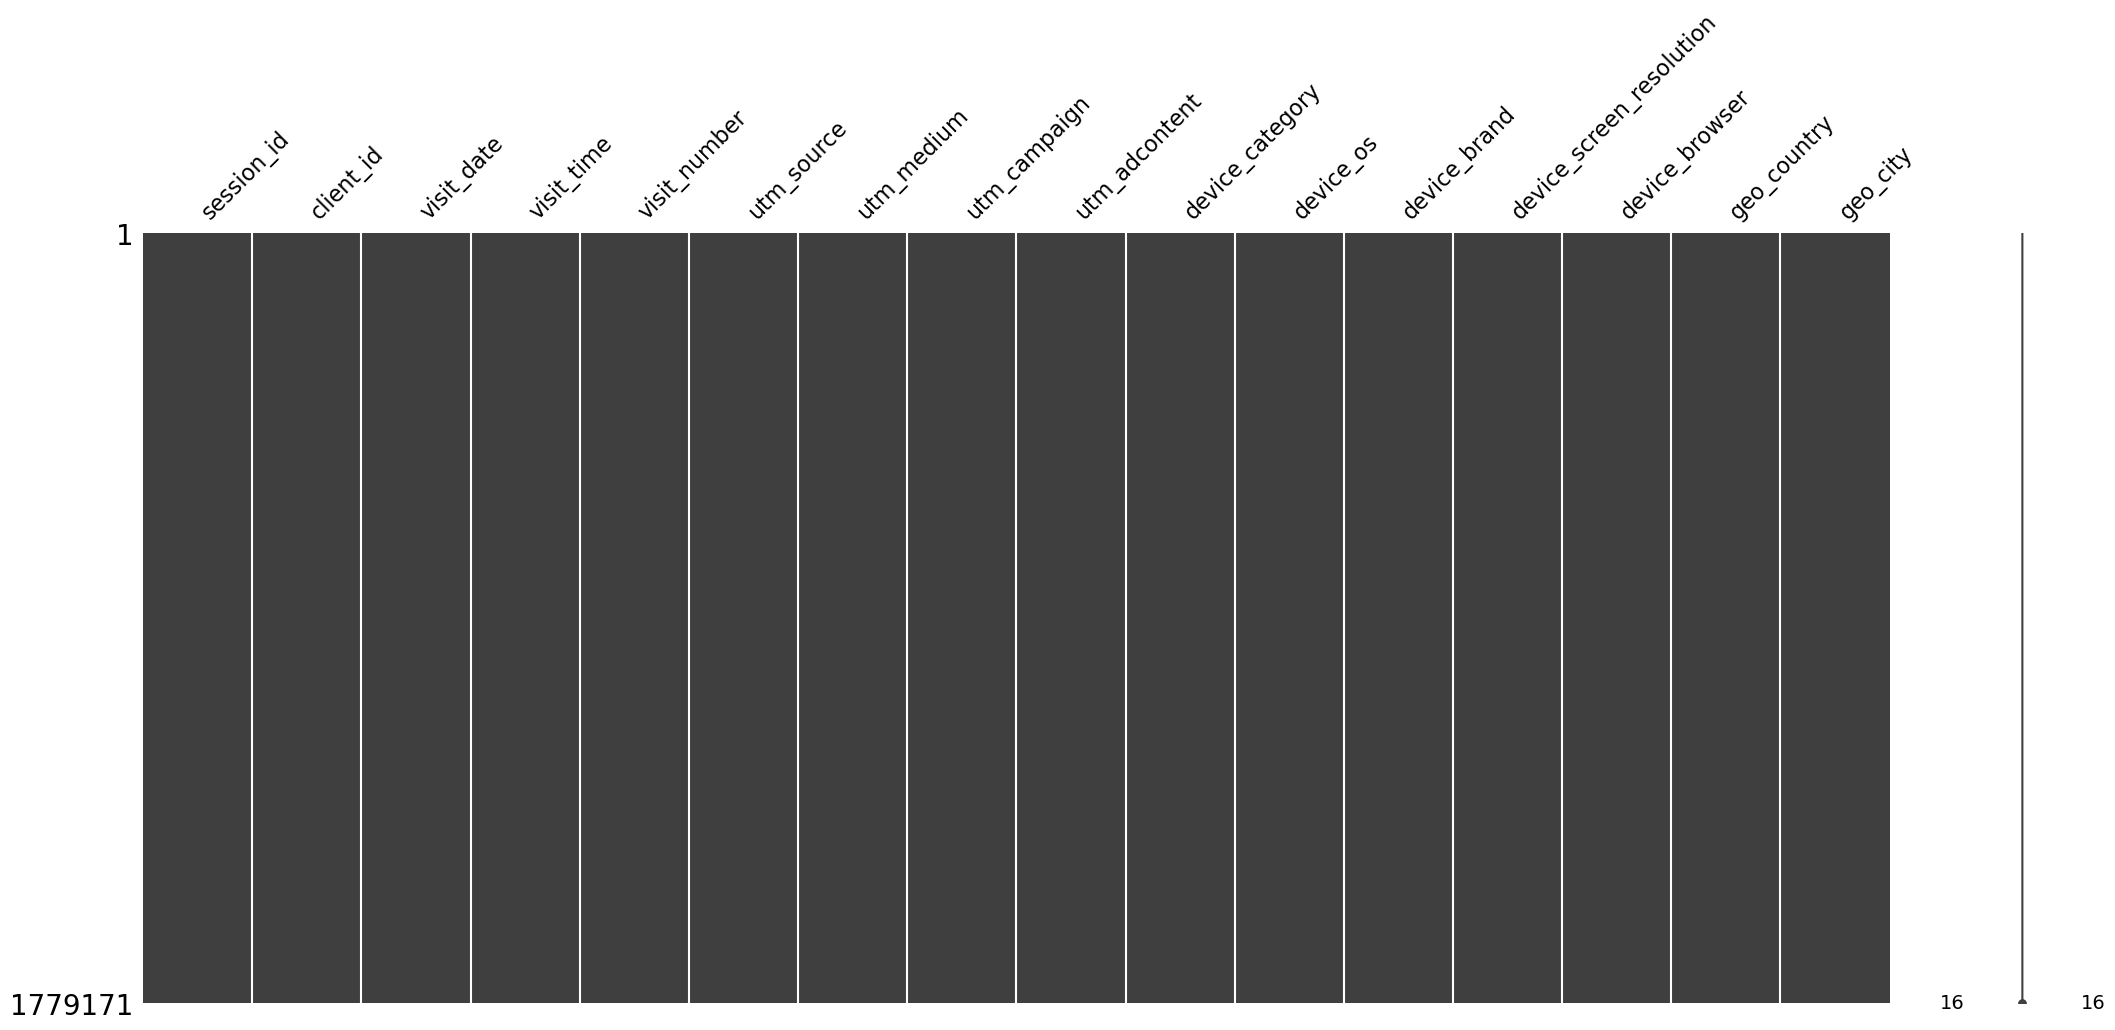

In [163]:
msno.matrix(df_sessions);

##### Сохранение промежуточных результатов

In [164]:
with open('data/ga_sessions_full.pkl', 'wb') as file:
    dill.dump(df_sessions, file)

### Feature engineering

In [192]:
with open('data/ga_sessions_full.pkl', 'rb') as file:
    df_sessions = dill.load(file)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow


In [193]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779171 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   device_category           object
 10  device_os                 object
 11  device_brand              object
 12  device_screen_resolution  object
 13  device_browser            object
 14  geo_country               object
 15  geo_city                  object
dtypes: int64(1), object(15)
memory usage: 230.8+ MB


##### Добавление целевого столбца из ga_hits

In [194]:
df_hits = pd.read_csv("data/ga_hits.csv")

df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [195]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


На этом этапе, чтобы не растягивать размер датафрейма, сразу обработаем столбец ***event_action***, и поместим в датафрейм новый признак ***target_action***, больше соответствующий целям задачи, а именно принимающий значение 1, если ***event_action*** входит в список целевых действий, и 0, если не входит

In [196]:
target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']

In [197]:
df_pa = df_hits[['session_id', 'event_action']]
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 240.0+ MB


Сперва создаём новый признак

In [198]:
df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)
df_pa.head()

C:\Users\Fiore\AppData\Local\Temp\ipykernel_19016\3902168040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pa['target_action'] = df_pa['event_action'].apply(lambda x: 1 if x in target_actions else 0)


,session_id,event_action,target_action
0,5639623078712724064.1640254056.1640254056,quiz_show,0
1,7750352294969115059.1640271109.1640271109,quiz_show,0
2,885342191847998240.1640235807.1640235807,quiz_show,0
3,142526202120934167.1640211014.1640211014,quiz_show,0
4,3450086108837475701.1640265078.1640265078,quiz_show,0


Группируем результат по ***session_id***, суммируя ***target_action***, чтобы получить в ***df_group_pa*** число совершённых целевых действий. По условию все значения > 1 считаем как 1 

In [199]:
df_group_pa = df_pa.groupby(['session_id']).agg({'target_action': 'sum'})
df_group_pa.loc[(df_group_pa['target_action'] > 1), 'target_action'] = 1

In [200]:
df_group_pa

,target_action
session_id,
1000009318903347362.1632663668.1632663668,0
1000010177899156286.1635013443.1635013443,0
1000013386240115915.1635402956.1635402956,0
1000017303238376207.1623489300.1623489300,0
1000020580299877109.1624943350.1624943350,0
...,...
999960188766601545.1626816843.1626816843,0
99996598443387715.1626811203.1626811203,0
999966717128502952.1638428330.1638428330,0


In [201]:
df_group_pa['target_action'].value_counts()

0    1683850
1      50760
Name: target_action, dtype: int64

Образуем новый датасет из ***df_sessions*** и ***df_group_pa***

In [202]:
df_joined = pd.merge(df_sessions, df_group_pa, on='session_id')

df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657112,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,1920x1080,Chrome,Russia,Moscow,0
1657113,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,390x844,Safari,Russia,Stavropol,0
1657114,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,375x667,Safari,Russia,Moscow,0
1657115,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0


In [203]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657117 entries, 0 to 1657116
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1657117 non-null  object
 1   client_id                 1657117 non-null  object
 2   visit_date                1657117 non-null  object
 3   visit_time                1657117 non-null  object
 4   visit_number              1657117 non-null  int64 
 5   utm_source                1657117 non-null  object
 6   utm_medium                1657117 non-null  object
 7   utm_campaign              1657117 non-null  object
 8   utm_adcontent             1657117 non-null  object
 9   device_category           1657117 non-null  object
 10  device_os                 1657117 non-null  object
 11  device_brand              1657117 non-null  object
 12  device_screen_resolution  1657117 non-null  object
 13  device_browser            1657117 non-null

In [204]:
df_joined['target_action'].value_counts()

0    1608494
1      48623
Name: target_action, dtype: int64

#### Обработка категориальных переменных

In [205]:
columns_df = df_joined.drop(columns=['session_id', 'client_id', 'visit_number', 'target_action']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце visit_date: 226
Уникальных значений в столбце visit_time: 84884
Уникальных значений в столбце utm_source: 279
Уникальных значений в столбце utm_medium: 50
Уникальных значений в столбце utm_campaign: 403
Уникальных значений в столбце utm_adcontent: 275
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 11
Уникальных значений в столбце device_brand: 198
Уникальных значений в столбце device_screen_resolution: 4799
Уникальных значений в столбце device_browser: 52
Уникальных значений в столбце geo_country: 140
Уникальных значений в столбце geo_city: 2354


Для использования OneHotEncoder в некоторых столбцах слишком много значений. Исправим это

***device_screen_resolution*** напрямую связана с ***device_category***, к тому же, в колонке перемешаны логические и физические разрешения, что мешает их градации. 
Удаляем колонку

In [206]:
df_joined = df_joined.drop(columns=['device_screen_resolution'])
df_joined

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657112,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,Chrome,Russia,Moscow,0
1657113,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,0
1657114,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,0
1657115,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0


Колонки ***visit_*** по условию задачи не нужны, значений в них много, поэтому удаляем

In [207]:
df_joined = df_joined.drop(columns=['visit_date', 'visit_time'])

Следующий столбец с большим числом значений - ***geo_city***. Заменим две колонки, ***geo_country*** и ***geo_city***, на две числовые колонки с широтой и долготой, и тогда они не будут кодироваться через One-Hot  

In [208]:
df_joined['geo_adress'] = df_joined.apply(lambda x: x['geo_country'] + ', ' + x['geo_city'], axis=1)
df_joined

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,geo_adress
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,"Russia, Zlatoust"
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,"Russia, Moscow"
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,"Russia, Krasnoyarsk"
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,"Russia, Moscow"
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,"Russia, Moscow"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657112,9055415581448263752.1640159305.1640159305,2108378238.1640159304,1,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,Chrome,Russia,Moscow,0,"Russia, Moscow"
1657113,9055421130527858185.1622007305.1622007305,2108379530.1622007305,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Stavropol,0,"Russia, Stavropol"
1657114,9055422955903931195.1636979515.1636979515,2108379955.1636979515,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Russia,Moscow,0,"Russia, Moscow"
1657115,905543020766873816.1638189404.1638189404,210838164.1638189272,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Chelyabinsk,0,"Russia, Chelyabinsk"


In [209]:
list_adresses = set(df_joined['geo_adress'].unique())
len(list_adresses)

2366

Уникальных значений координат тоже будет многовато для кодирования, поэтому воспользуемся другим способом сократить число значений  

Ограничим число городов по топ-100 визитов, т. е., если из города приходило запросов меньше 100, ставим ему значение other

In [212]:
# принимает на вход df_data - датафрейм, в котором необходимо выделить в колонке column n самых часто встречаемых значений
def get_top(df_data, column, n=100):
    df_stat = df_data.groupby(column).agg({column: 'count'})
    df_stat = df_stat.rename(columns={column: 'count_' + column})
    
    df_stat = df_stat.sort_values(by='count_' + column, ascending=False)
    city_top = list(df_stat[df_stat['count_' + column] > n].index)

    return city_top

In [210]:
city_top = get_top(df_joined, 'geo_city')

In [211]:
df_joined['geo_city_short'] = df_joined['geo_city'].apply(lambda x: x if x in city_top else 'other')
print("Число уникальных значений в новой колонке", len(df_joined['geo_city_short'].unique()))

Число уникальных значений в новой колонке 329


Проделаем аналогичный ход с ***geo_country***

In [213]:
country_top = get_top(df_joined, 'geo_country')
df_joined['geo_country_short'] = df_joined['geo_country'].apply(lambda x: x if x in country_top else 'other')
print("Число уникальных значений в новой колонке", len(df_joined['geo_country_short'].unique()))

Число уникальных значений в новой колонке 48


In [214]:
df_joined.head()

,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,geo_city,target_action,geo_adress,geo_city_short,geo_country_short
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Zlatoust,0,"Russia, Zlatoust",Zlatoust,Russia
1,905544597018549464.1636867290.1636867290,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,0,"Russia, Moscow",Moscow,Russia
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,0,"Russia, Krasnoyarsk",Krasnoyarsk,Russia
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,"Russia, Moscow",Moscow,Russia
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Russia,Moscow,0,"Russia, Moscow",Moscow,Russia


In [215]:
df_joined = df_joined.drop(columns=['geo_country', 'geo_city', 'geo_adress'])

In [216]:
columns_df = df_joined.drop(columns=['session_id', 'client_id', 'visit_number', 'target_action']).columns
for col in columns_df:
    print(f"Уникальных значений в столбце {col}: {len(df_joined[col].unique())}")

Уникальных значений в столбце utm_source: 279
Уникальных значений в столбце utm_medium: 50
Уникальных значений в столбце utm_campaign: 403
Уникальных значений в столбце utm_adcontent: 275
Уникальных значений в столбце device_category: 3
Уникальных значений в столбце device_os: 11
Уникальных значений в столбце device_brand: 198
Уникальных значений в столбце device_browser: 52
Уникальных значений в столбце geo_city_short: 329
Уникальных значений в столбце geo_country_short: 48


In [217]:
with open('data/ga_joined.pkl', 'wb') as file:
    dill.dump(df_joined, file)

In [218]:
with open('data/ga_joined.pkl', 'rb') as file:
    df_joined = dill.load(file)
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657117 entries, 0 to 1657116
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   session_id         1657117 non-null  object
 1   client_id          1657117 non-null  object
 2   visit_number       1657117 non-null  int64 
 3   utm_source         1657117 non-null  object
 4   utm_medium         1657117 non-null  object
 5   utm_campaign       1657117 non-null  object
 6   utm_adcontent      1657117 non-null  object
 7   device_category    1657117 non-null  object
 8   device_os          1657117 non-null  object
 9   device_brand       1657117 non-null  object
 10  device_browser     1657117 non-null  object
 11  target_action      1657117 non-null  int64 
 12  geo_city_short     1657117 non-null  object
 13  geo_country_short  1657117 non-null  object
dtypes: int64(2), object(12)
memory usage: 189.6+ MB


In [53]:
data_ohe = df_joined.drop(columns=['session_id', 'client_id', 'geo_city', 'geo_country', 'visit_number', 'target_action'])
data_ohe

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_city_short,geo_country_short
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Zlatoust,Russia
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Moscow,Russia
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Krasnoyarsk,Russia
3,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,mobile,Android,Xiaomi,Chrome,Moscow,Russia
4,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Moscow,Russia
...,...,...,...,...,...,...,...,...,...,...
1658459,BHcvLfOaCWvWTykYqHVe,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,desktop,Windows,other,Chrome,Moscow,Russia
1658460,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Stavropol,Russia
1658461,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,iOS,Apple,Safari,Moscow,Russia
1658462,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Android,Xiaomi,Chrome,Chelyabinsk,Russia


In [54]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(data_ohe)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [207]:
matrix_trans = ohe.transform(data_ohe)
data_ohe[ohe.get_feature_names_out()] = matrix_trans

##### Выгрузка результатов

In [1]:
df_joined.to_csv('data/ga_completed.csv', index=False)

NameError: name 'df_joined' is not defined

#### Исследование данных

##### Загрузка данных

In [20]:
df_intell = pd.read_csv("data/ga_completed.csv")

df_intell.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Zlatoust,sub_landing
1,9055434745589932991.1637753792.1637753792,2.108383e+09,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Zlatoust,sub_view_cars_click
2,905544597018549464.1636867290.1636867290,2.108385e+08,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,qBRdfuuhOnnqwSqNiPOv,385x854,Samsung Internet,Russia,Moscow,sub_landing
3,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Krasnoyarsk,search_form_region
4,9055446045651783499.1640648526.1640648526,2.108385e+09,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Krasnoyarsk,search_form_region


##### Проверка и преобразование типа

In [21]:
df_intell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15684456 entries, 0 to 15684455
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   session_id                object 
 1   client_id                 float64
 2   visit_date                object 
 3   visit_time                object 
 4   visit_number              int64  
 5   utm_source                object 
 6   utm_medium                object 
 7   utm_campaign              object 
 8   utm_adcontent             object 
 9   utm_keyword               object 
 10  device_category           object 
 11  device_os                 object 
 12  device_brand              object 
 13  device_model              object 
 14  device_screen_resolution  object 
 15  device_browser            object 
 16  geo_country               object 
 17  geo_city                  object 
 18  event_action              object 
dtypes: float64(1), int64(1), object(17)
memory usage: 2.2+ GB


In [22]:
df_intell['client_id'] = df_intell['client_id'].astype('str')
df_intell.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Zlatoust,sub_landing
1,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Zlatoust,sub_view_cars_click
2,905544597018549464.1636867290.1636867290,210838531.16368672,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,qBRdfuuhOnnqwSqNiPOv,385x854,Samsung Internet,Russia,Moscow,sub_landing
3,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Krasnoyarsk,search_form_region
4,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Krasnoyarsk,search_form_region


Объединим дату и время в один столбец, чтобы корректно его преобразовать в тип datetime

In [21]:
df_joined['visit_datetime'] = df_joined['visit_date'].astype(str) + ' ' + df_joined['visit_time'].astype(str)
df_joined['visit_datetime'] = pd.to_datetime(df_joined['visit_datetime'])

In [22]:
cols = list(df_joined.columns)
cols.insert(2, cols.pop(len(cols) - 1))
df_joined = df_joined[cols]
df_joined.head()

,session_id,client_id,visit_datetime,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,purpose_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24 14:36:32,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14 08:21:30,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,qBRdfuuhOnnqwSqNiPOv,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28 02:42:06,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,AuMdmADEIoPXiWpTsBEj,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29 05:00:00,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,NOBKLgtuvqYWkXQHeYWM,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,qBRdfuuhOnnqwSqNiPOv,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29 05:00:00,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,qBRdfuuhOnnqwSqNiPOv,393x786,Chrome,Russia,Moscow,0


In [12]:
df_intell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15684456 entries, 0 to 15684455
Data columns (total 20 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_id                object        
 1   client_id                 float64       
 2   visit_datetime            datetime64[ns]
 3   visit_date                object        
 4   visit_time                object        
 5   visit_number              int64         
 6   utm_source                object        
 7   utm_medium                object        
 8   utm_campaign              object        
 9   utm_adcontent             object        
 10  utm_keyword               object        
 11  device_category           object        
 12  device_os                 object        
 13  device_brand              object        
 14  device_model              object        
 15  device_screen_resolution  object        
 16  device_browser            object        
 17  geo_co

In [14]:
get_and_check_min_max_bounds(df_intell, 'visit_datetime')

min входит в границы нормальных значений
max входит в границы нормальных значений


(Timestamp('2021-01-26 12:02:30'), Timestamp('2022-05-22 01:15:50'))

In [13]:
df_intell['event_action'].unique()

array(['sub_landing', 'sub_view_cars_click', 'search_form_region',
       'quiz_show', 'search_form_search_btn', 'view_card', 'sub_car_page',
       'view_new_card', 'quiz_start', 'search_kpp', 'search_drive',
       'chat requested', 'go_to_car_card', 'chat established',
       'listing_ads_sort', 'search_form_rental', 'search_form_cost_to',
       'search_form_cost_from', 'search_steering_wheel',
       'proactive invitation shown', 'proactive invitation accepted',
       'user gave contacts during chat',
       'search_form_search_car_type_select', 'view_more_click',
       'sub_offer_click', 'sub_footer_link_click', 'start_auth',
       'show_phone_input', 'go_to_terms', 'search_form_mark_select',
       'photos_all', 'showed_number_ads', 'search_form_model_select',
       'search_form_model_multiselec', 'greenday_get_gift',
       'pagination_click', 'search_form_year_from', 'photos',
       'go_to_offer', 'sub_header_link_click', 'click_on_logo',
       'search_form_modification_

##### Исследование распределения visit_datetime, visit_date и visit_time

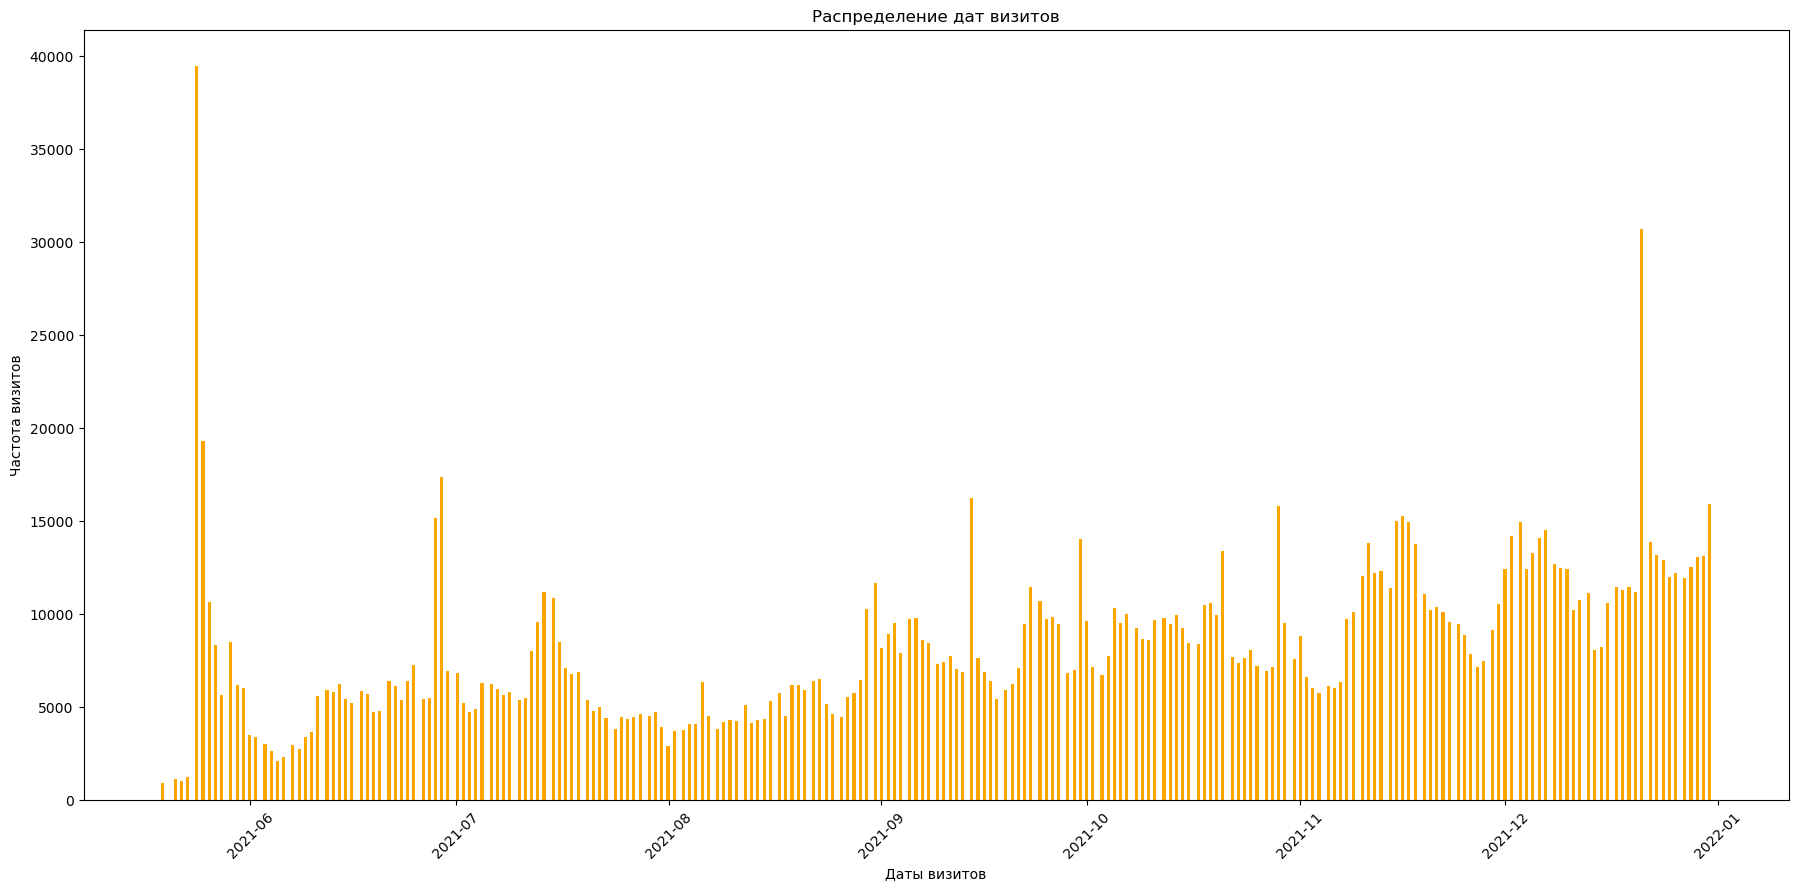

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=45)

ax1.hist(df_intell['visit_date'], color='orange', bins=500)
ax1.set_xlabel('Даты визитов')
ax1.set_ylabel('Частота визитов')
ax1.set_title('Распределение дат визитов');

##### Исследование распределения utm_source

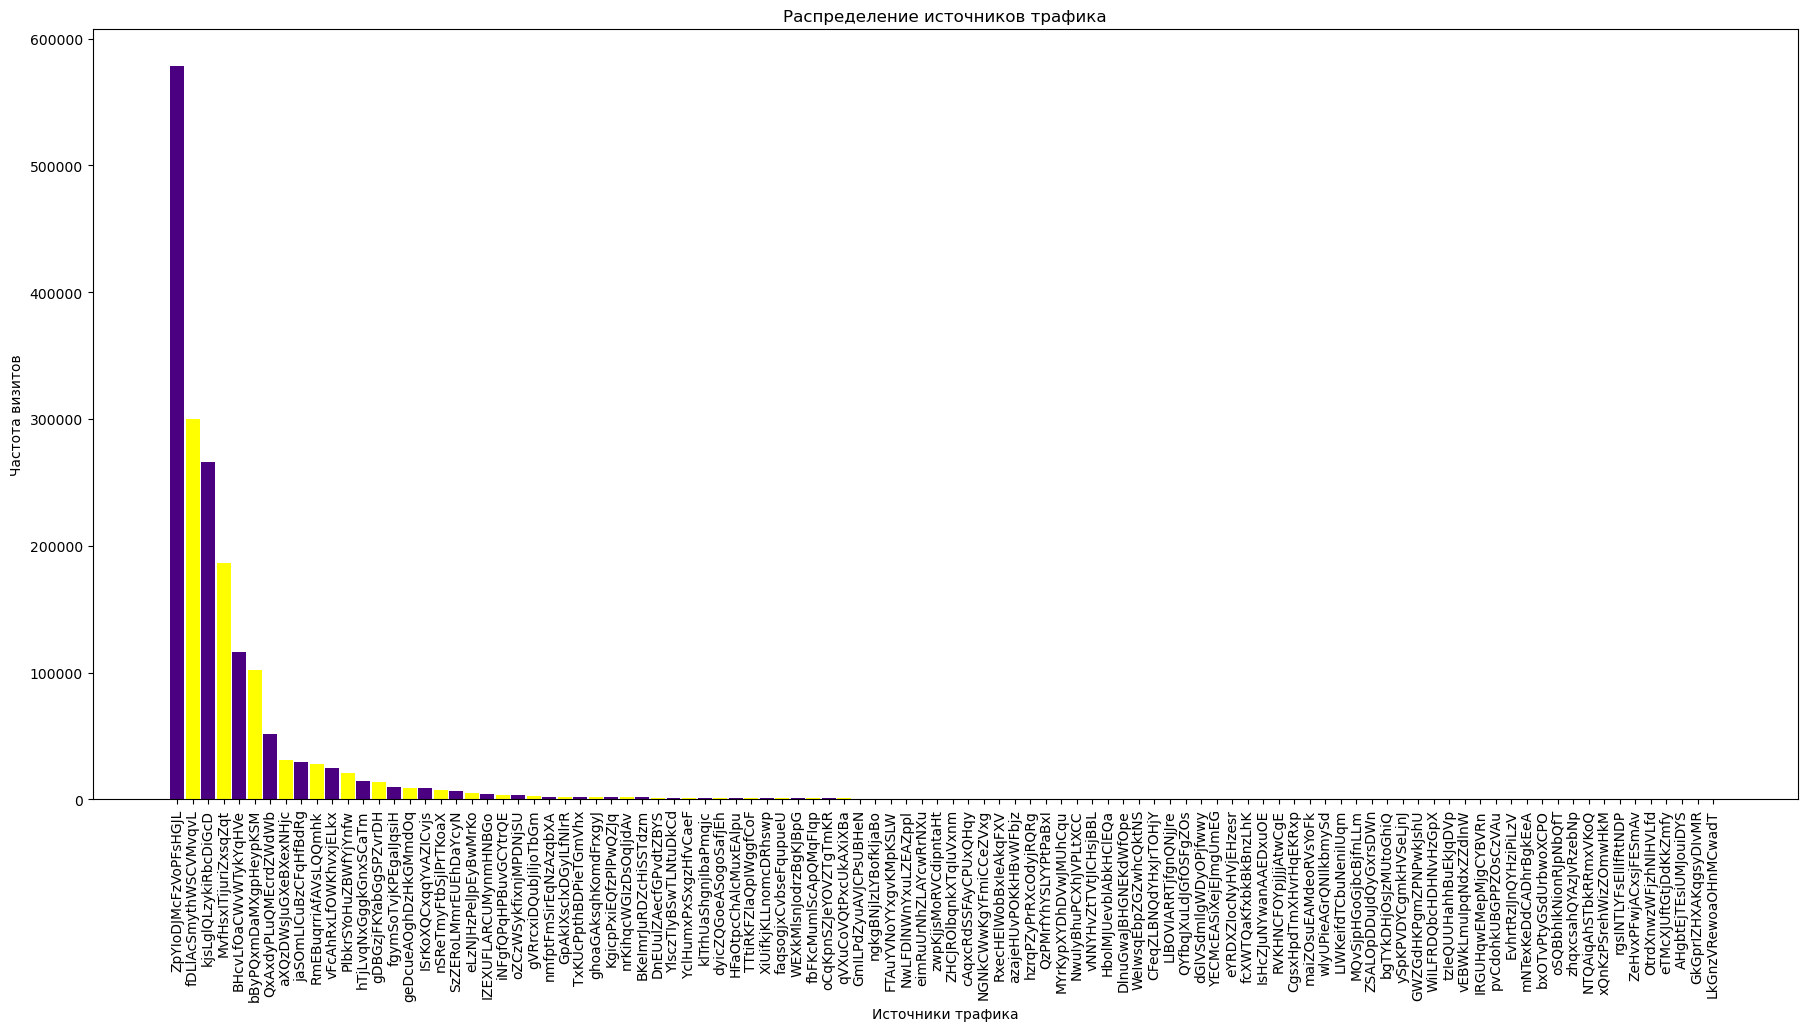

In [15]:
df_sources = df_intell.groupby('utm_source').agg({'utm_source': 'count'})
df_sources = df_sources.rename(columns={'utm_source': 'goes_from'})
df_sessions_source = df_sources['goes_from'].sort_values(ascending=False)[0:100]


fig, ax3 = plt.subplots(figsize=(15, 10))

ax3.bar(df_sessions_source.index, df_sessions_source, width=0.9, color=['indigo', 'yellow'])
plt.xticks(rotation=90)

plt.xlabel('Источники трафика')
plt.ylabel('Частота визитов')
plt.title('Распределение источников трафика');

##### Исследование распределения device_brand

In [16]:
df_brands = df_intell.groupby('device_brand').agg({'device_brand': 'count'})
df_brands = df_brands.rename(columns={'device_brand': 'produced_by_brand'})
df_sessions_brands = df_brands['produced_by_brand'].sort_values(ascending=False)[0:100]

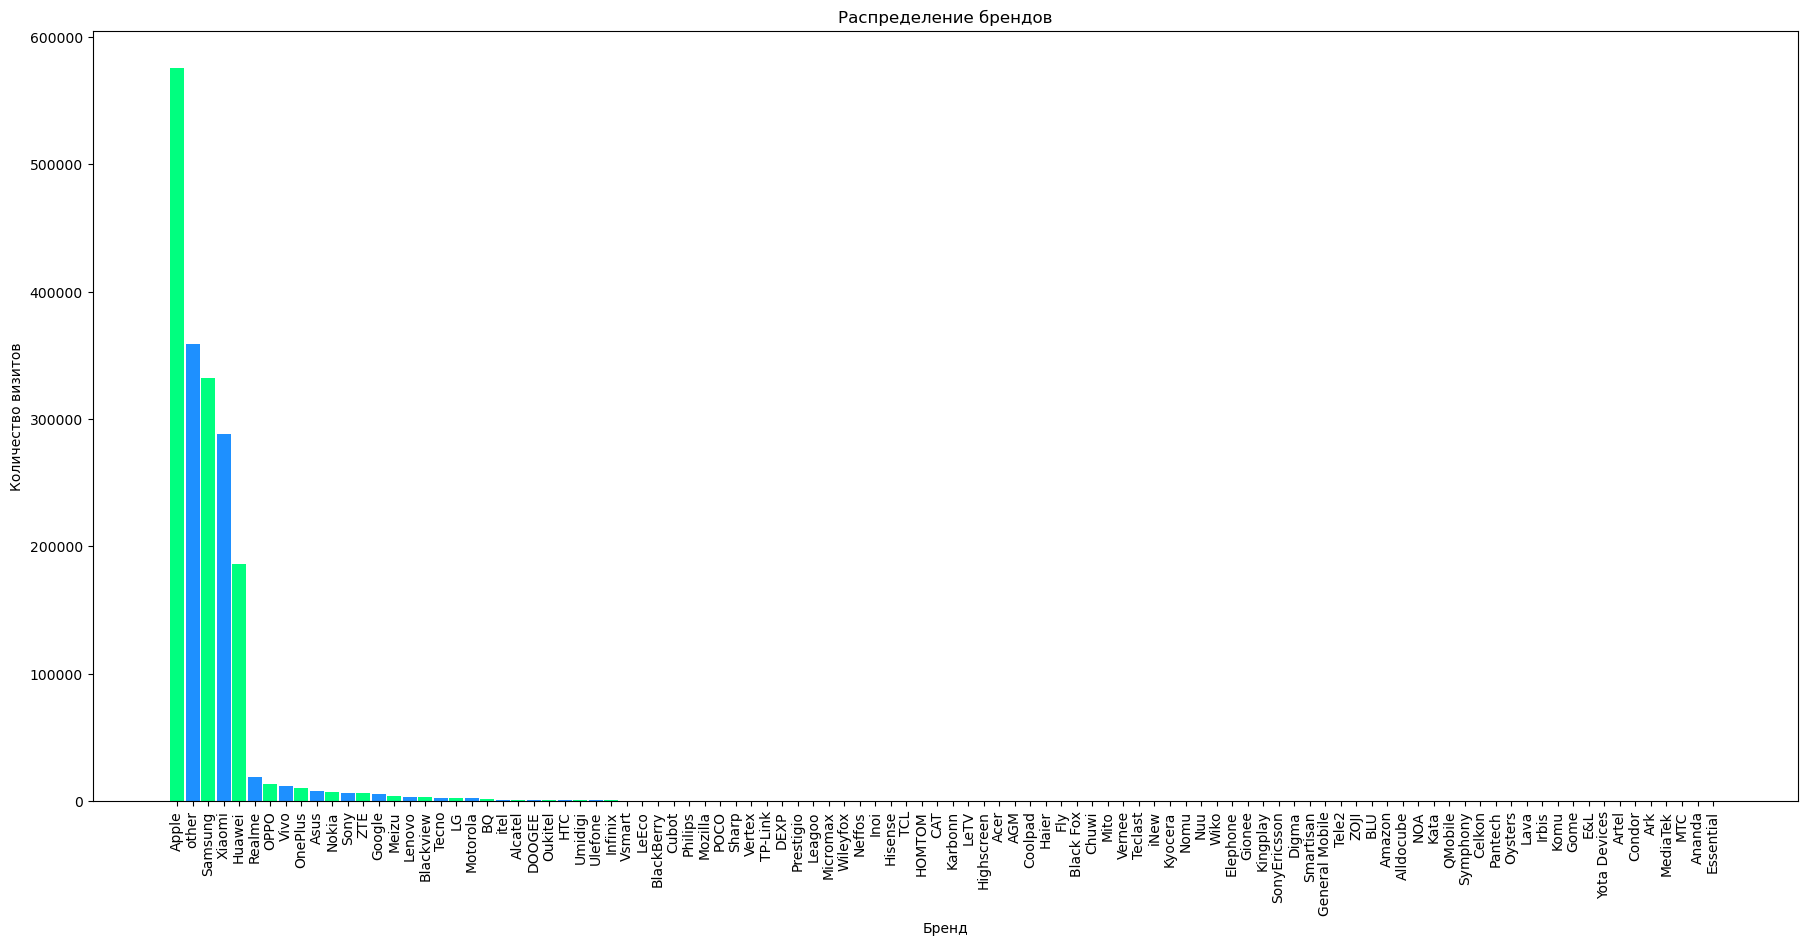

In [17]:
fig, cx = plt.subplots(figsize=(22, 10))

cx.bar(df_sessions_brands.index, df_sessions_brands, width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('Бренд')
plt.ylabel('Количество визитов')
plt.title('Распределение брендов');

##### Исследование распределения utm_medium

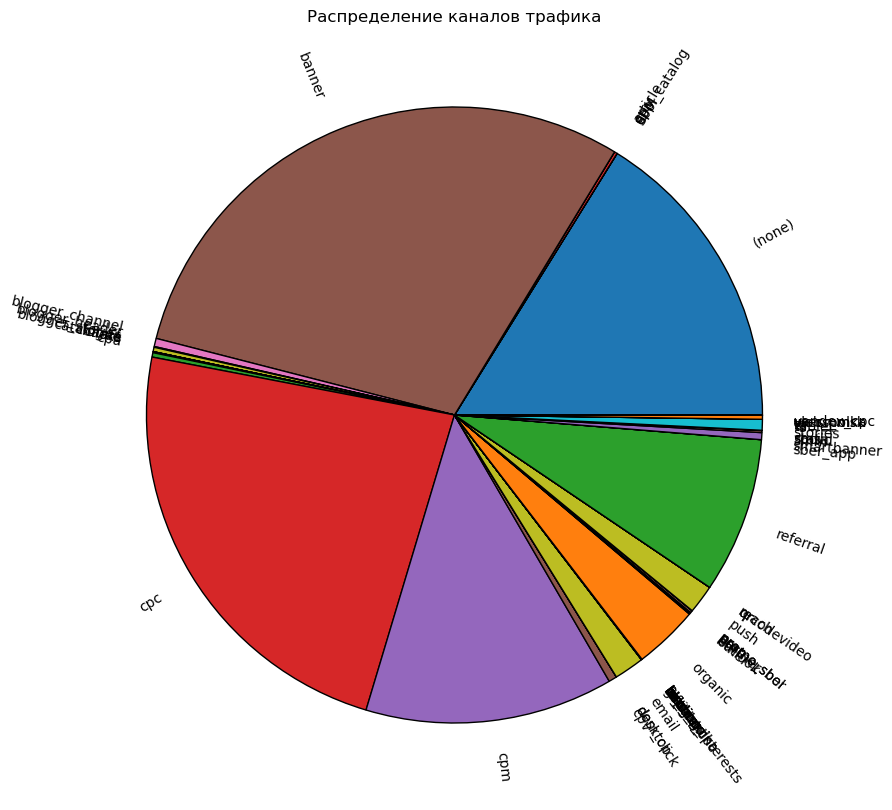

In [18]:
df_medium_stat = df_intell.groupby('utm_medium').agg({'utm_medium': 'count'})
df_medium_stat = df_medium_stat.rename(columns={'utm_medium': 'count_of_medium'})

fig, ex = plt.subplots(figsize=(22, 10))

plt.pie(df_medium_stat['count_of_medium'], labels=df_medium_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение каналов трафика")
#plt.legend(loc='lower left', ncol=len(df_medium_stat))
plt.show();

##### Исследование распределения device_category

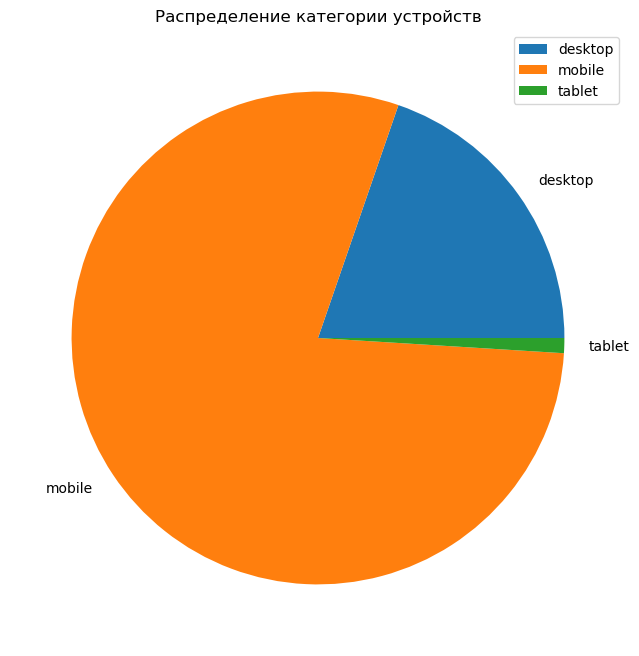

In [19]:
df_categories_stat = df_intell.groupby('device_category').agg({'device_category': 'count'})
df_categories_stat = df_categories_stat.rename(columns={'device_category': 'count_of_category'})

fig, dx = plt.subplots(figsize=(12, 8))

plt.pie(df_categories_stat['count_of_category'], labels=df_categories_stat.index)
plt.title("Распределение категории устройств")
plt.legend()
plt.show();

##### Исследование распределения device_os

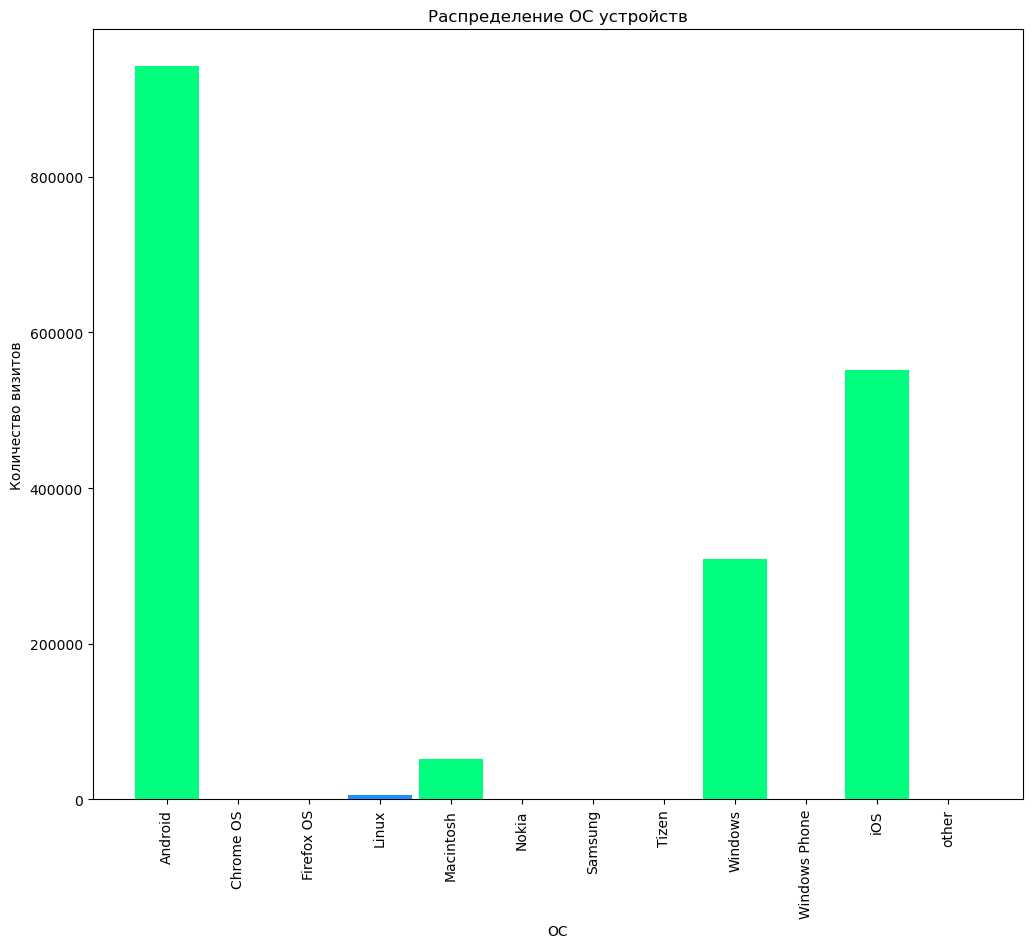

In [20]:
df_os_stat = df_intell.groupby('device_os').agg({'device_os': 'count'})
df_os_stat = df_os_stat.rename(columns={'device_os': 'count_of_os'})

fig, dx = plt.subplots(figsize=(12, 10))

dx.bar(df_os_stat.index, df_os_stat['count_of_os'], width=0.9, color=['springgreen', 'dodgerblue'])
plt.xticks(rotation=90)

plt.xlabel('ОС')
plt.ylabel('Количество визитов')
plt.title("Распределение ОC устройств");

##### Исследование распределения geo_country

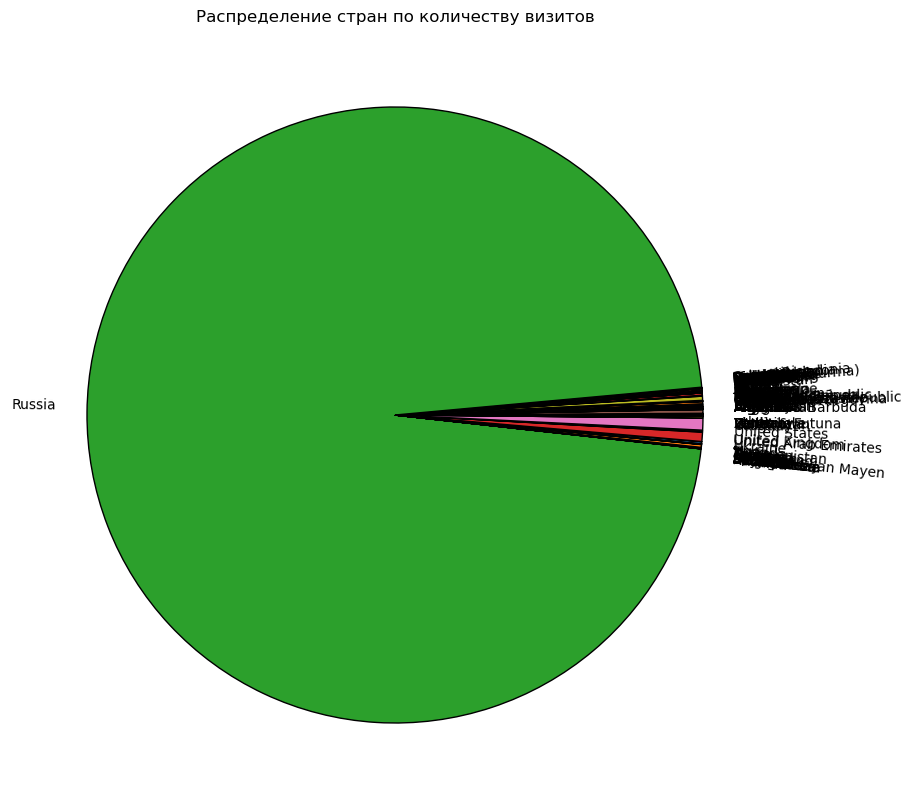

In [21]:
df_country_stat = df_intell.groupby('geo_country').agg({'geo_country': 'count'})
df_country_stat = df_country_stat.rename(columns={'geo_country': 'count_of_visits_countries'})

fig, fx = plt.subplots(figsize=(22, 10))

plt.pie(df_country_stat['count_of_visits_countries'], labels=df_country_stat.index, rotatelabels=True, wedgeprops={"edgecolor":"k",'linewidth': 1})
plt.title("Распределение стран по количеству визитов")
plt.show();